In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import mpl_toolkits as mpltk
from geopy.distance import vincenty
import cartopy.crs as ccrs

In [3]:
data_srs_no_null = pd.read_csv('../data/PeMS/Series/light/d07_text_station_5min_2017_10_11.csv', parse_dates=[0])

In [19]:
data_srs_no_null_04 = pd.read_csv('../data/PeMS/Series/light/d07_text_station_5min_2017_10_04.csv', parse_dates=[0])

In [12]:
data_srs_smoothed = pd.read_csv('../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_11.csv', parse_dates=[0])

In [24]:
data_srs_smoothed_04 = pd.read_csv('../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_04.csv', parse_dates=[0])

In [6]:
data_inc_d07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_11.csv', parse_dates=[3])

In [29]:
data_inc_04_d07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_04.csv', parse_dates=[3])

In [1048]:
data_det_inc_07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_det_day_2017_10_11.csv', parse_dates=[2])

In [33]:
stations_active = pd.read_csv('../data/PeMS/Stations/light/d07_text_meta_2017_09_20_active.csv')

In [36]:
def drop_nulls_column(data, c_name):
    return data.dropna(subset=[c_name])

In [40]:
def plot_flow_w_incidents(flow_data, incdnt_data, frw_no, station_no, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=8)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=20)
    data_srs_no_null = flow_data.dropna(subset=[chrstc_to_plot])
    data_incdnts_by_frw = incdnt_data[incdnt_data['Freeway']==frw_no]
    dates = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)]['Timestamp']
    speed = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)][chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_by_frw['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

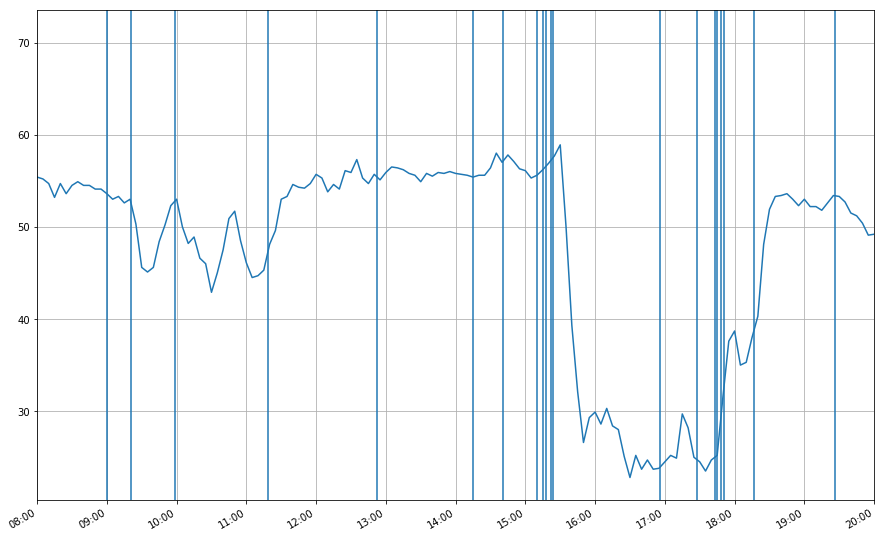

In [41]:
plot_flow_w_incidents(data_srs_no_null, data_inc_d07, 101, 716328)

In [42]:
def show_unique_freeways(data):
#     result = np.empty([0,len(data.columns)])
    maximum=0
    for st in data['Station'].unique():
#         result = np.append(result, data[data['Station'] == st])
        crnt_len = len(data[data['Station'] == st]['Freeway'].unique())
        if crnt_len > maximum:
            maximum = crnt_len
    return maximum

In [44]:
print(show_unique_freeways(data_srs_no_null))

1


In [46]:
min_lon = stations_active['Longitude'].min()
max_lon = stations_active['Longitude'].max()
min_lat = stations_active['Latitude'].min()
max_lat = stations_active['Latitude'].max()

In [47]:
st1_coords = (stations_active['Latitude'][0], stations_active['Longitude'][0])
st2_coords = (stations_active['Latitude'][1], stations_active['Longitude'][1])
st1_coords_ccrs = [stations_active['Latitude'][0], stations_active['Longitude'][0]]

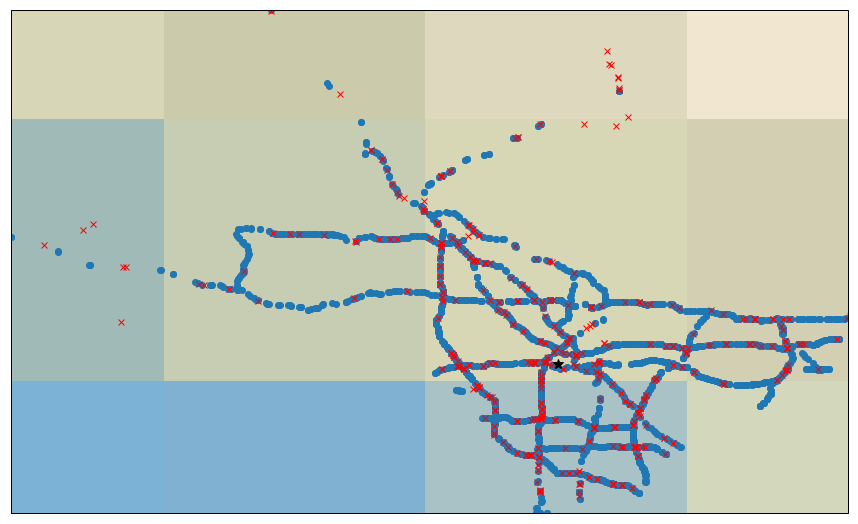

In [50]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(stations_active['Longitude'], stations_active['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'], data_inc_d07[data_inc_d07['District']==7]['Latitude'], marker='x', color='red', linestyle='')
plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean()-.05, marker='*', markersize=10, color='black', linestyle='')
# ax.set_xlim()
# ax.set_extent((min_lon-10, max_lon+10, min_lat-10, max_lat+10))
ax.set_extent((min_lon, max_lon, min_lat, max_lat))
plt.show()

In [52]:
most_accidentious_spot = [data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean()-.05]
min_dist = 100 
limit_i=100000
for i in range(stations_active.shape[0]):
    st_coords = [stations_active['Latitude'][i], stations_active['Longitude'][i]]
#     print(st_coords)
    crnt_dist = vincenty(most_accidentious_spot, st_coords).kilometers
    if crnt_dist < min_dist:
        min_dist = crnt_dist
        index=i
    if i>limit_i:
        break
print('From hot spot to the closest station {0:.3f} km'.format(min_dist))
print('Station closest to hot spot {} (ID={})'.format(index, stations_active.loc[index]['ID']))

From hot spot to the closest station 0.095 km
Station closest to hot spot 462 (ID=717459)


In [53]:
stations_active[stations_active.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), most_accidentious_spot).kilometers < 1, axis=1)].shape

(5, 18)

In [329]:
def plot_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=0)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

In [508]:
def plot_two_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no1, station_no2, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=0)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null_1 = flow_data[flow_data['Station'] == station_no1]
    data_srs_no_null_2 = flow_data[flow_data['Station'] == station_no2]
#     data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no1][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates1 = data_srs_no_null_1['Timestamp']
    dates2 = data_srs_no_null_2['Timestamp']
    # y-values
    speed1 = data_srs_no_null_1[chrstc_to_plot]
    speed2 = data_srs_no_null_2[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates1, speed1, fmt='-', tz='EST')
    plt.plot_date(dates2, speed2, fmt='-', tz='EST', color='r')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

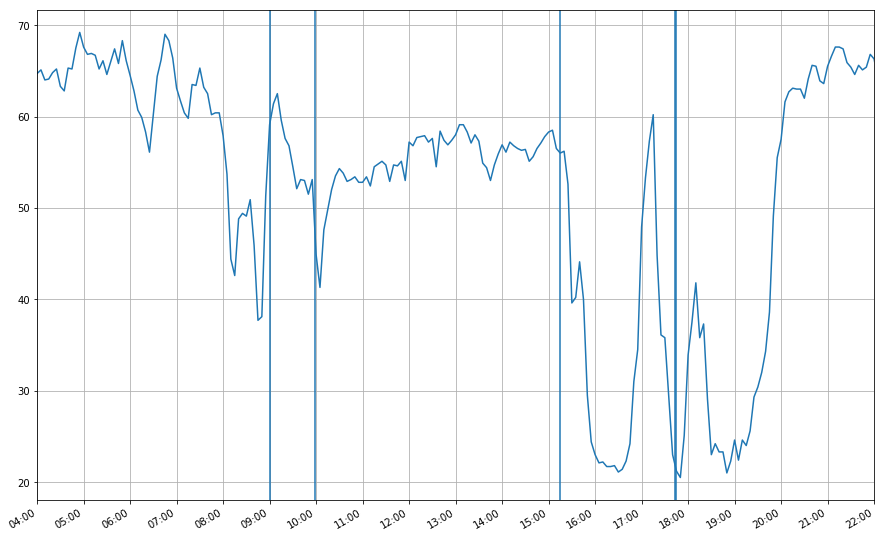

In [55]:
plot_station_data_w_nearest_incds(data_srs_no_null, data_inc_d07, stations_active, 717459, vicinity_km=3)

##  Analysis of incidents impact

In [71]:
def isImpacted(srs, ts, ticks_to_count=3, slowing_coef = .66):
    srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[srs['Timestamp'] > ts].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    if(slowing_coef * srs_b4['Avg Speed'].mean() > srs_after['Avg Speed'].mean()):
        return True
    return False
isImpacted_vec = np.vectorize(isImpacted, excluded=[1,2])

In [962]:
def isImpactedWithNextSt(stationID, n_stationID, srs, ts, ticks_to_count=4, slowing_coef = .9):
#     srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_b4 = srs[(srs['Timestamp'] < ts) & (srs['Station']==stationID)].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    n_srs_b4 = srs[(srs['Timestamp'] < ts) & (srs['Station']==n_stationID)].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[(srs['Timestamp'] > ts) & (srs['Station']==stationID)].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    n_srs_after = srs[(srs['Timestamp'] > ts) & (srs['Station']==n_stationID)].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
#     if (stationID==769405) & (n_stationID==769403):
#         print('{}\n {}'.format(srs_after[['Avg Speed', 'Timestamp']], n_srs_after[['Avg Speed', 'Timestamp']]))
#     cond1 = slowing_coef * n_srs_after['Avg Speed'].mean() > srs_after['Avg Speed'].mean()
#     cond2 = 1.1*np.abs(n_srs_b4['Avg Speed'].mean()-srs_b4['Avg Speed'].mean()) < np.abs(n_srs_after['Avg Speed'].mean()-srs_after['Avg Speed'].mean())
    cond1 = n_srs_b4['Avg Speed'].as_matrix().dot(srs_b4['Avg Speed'].as_matrix())
    cond2 = n_srs_after['Avg Speed'].as_matrix().dot(srs_after['Avg Speed'].as_matrix())
    cond3 = slowing_coef*n_srs_after['Avg Speed'].mean() > srs_after['Avg Speed'].mean()
#     print('{} {}'.format(slowing_coef*cond1 , cond2))
#     print('{} {}'.format(n_srs_b4['Avg Speed'].as_matrix() , srs_b4['Avg Speed'].as_matrix()))
#     print('{} {}'.format(n_srs_after['Avg Speed'].as_matrix() , srs_after['Avg Speed'].as_matrix()))
#     print('{} {}'.format(n_srs_b4['Timestamp'].as_matrix() , srs_b4['Timestamp'].as_matrix()))
#     print('{} {}'.format(n_srs_after['Timestamp'].as_matrix() , srs_after['Timestamp'].as_matrix()))
    if slowing_coef*cond1 > cond2 and cond3: 
        return True
    return False

In [963]:
isImpactedWithNextSt(stID, 769405,  data_srs_smoothed, data_inc_d07[data_inc_d07.IncidentID == 17521284].Timestamp.iloc[0])

False

In [59]:
def return_station_series(srs, station):
    return srs[srs['Station']==station]
return_station_series_vec = np.vectorize(return_station_series, excluded=[0])

In [60]:
tinc = data_inc_d07.iloc[6]

In [61]:
tst = stations_active[stations_active['Dir'] == tinc['Freeway_direction']]

In [62]:
def filter_proper_direction(incident, stations):
    target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        target_stations = target_stations[target_stations['Latitude']<incident['Latitude']]
    elif incident['Freeway_direction'] == 'E':
        target_stations = target_stations[target_stations['Longitude']<incident['Longitude']]
    elif incident['Freeway_direction'] == 'S':
        target_stations = target_stations[target_stations['Latitude']>incident['Latitude']]
    elif incident['Freeway_direction'] == 'W':
        target_stations = target_stations[target_stations['Longitude']>incident['Longitude']]
    return target_stations

In [63]:
def isDirectionMatching(incident, station):
#     target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        return station['Latitude']<incident['Latitude']
    elif incident['Freeway_direction'] == 'E':
        return station['Longitude']<incident['Longitude']
    elif incident['Freeway_direction'] == 'S':
        return station['Latitude']>incident['Latitude']
    elif incident['Freeway_direction'] == 'W':
        return station['Longitude']>incident['Longitude']
    return False

In [64]:
def isDirectionCMatching(incident, station):
#     target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        return station['Latitude']>incident['Latitude']
    elif incident['Freeway_direction'] == 'E':
        return station['Longitude']>incident['Longitude']
    elif incident['Freeway_direction'] == 'S':
        return station['Latitude']<incident['Latitude']
    elif incident['Freeway_direction'] == 'W':
        return station['Longitude']<incident['Longitude']
    return False

In [183]:
stations_active.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.430,ML,3,PHOEBE,2029,NaN,NaN,NaN
1,715918,5,N,7,37,52526.0,6.2,122.833,33.933110,-118.091005,1.075,ML,3,ORR - DAY,2579,NaN,NaN,NaN
2,715920,5,S,7,37,52526.0,6.64,123.210,33.938544,-118.094941,1.290,ML,4,S OF 605,2296,NaN,NaN,NaN
3,715929,5,S,7,37,19766.0,9.5,126.070,33.971707,-118.123095,0.470,ML,4,GUATEMALA,2023,NaN,NaN,NaN
4,715930,5,N,7,37,19766.0,9.5,126.133,33.971763,-118.122905,0.505,ML,4,GUATEMALA,2023,NaN,NaN,NaN


In [908]:
def get_next_downstream_station(stations, stationID, incidents, incidentID, correction=.002):
    meta = stations[stations.ID==stationID].iloc[0][['Fwy', 'Dir', 'Latitude', 'Longitude']]
    candidates = stations[(stations['Fwy']==meta[0])&(stations['Dir']==meta[1])].drop(stations.columns[-4:], axis=1).copy()
    if meta[1] == 'S':
        candidates.loc[:,'Distance'] = meta[-2] - candidates['Latitude']
        cond1 = candidates['Latitude'] < incidents[incidents['IncidentID']==incidentID].iloc[0]['Latitude'] - correction
    elif meta[1] == 'N':
        candidates.loc[:,'Distance'] = candidates['Latitude'] - meta[-2]
        cond1 = candidates['Latitude'] > incidents[incidents['IncidentID']==incidentID].iloc[0]['Latitude'] + correction
    elif meta[1] == 'W':
        candidates.loc[:,'Distance'] = meta[-1] - candidates['Longitude']
        cond1 = candidates['Longitude'] < incidents[incidents['IncidentID']==incidentID].iloc[0]['Longitude'] - correction
    else : # meta[1] == 'E':
        candidates.loc[:,'Distance'] = candidates['Longitude'] - meta[-1]
        cond1 = candidates['Longitude'] > incidents[incidents['IncidentID']==incidentID].iloc[0]['Longitude'] + correction
    cond2 = (np.abs(candidates['Distance'])<0.025)
#     print(incidents[incidents['IncidentID']==incidentID].iloc[0])
    return candidates[cond1 & cond2 & (candidates['Distance'] > 0)].sort_values(['Distance']).reset_index(drop=True)

In [880]:
def get_neighbouring_station(stations, stationID):
    meta = stations[stations.ID==stationID].iloc[0][['Fwy', 'Dir', 'Latitude', 'Longitude']]
    candidates = stations[(stations['Fwy']==meta[0])&(stations['Dir']==meta[1])].drop(stations.columns[-4:], axis=1).copy()
    if meta[1] == 'S':
        candidates.loc[:,'Distance'] = meta[-2] - candidates['Latitude']
#         cond = 
    elif meta[1] == 'N':
        candidates.loc[:,'Distance'] = candidates['Latitude'] - meta[-2]
    elif meta[1] == 'W':
        candidates.loc[:,'Distance'] = meta[-1] - candidates['Longitude']
    else : # meta[1] == 'E':
        candidates.loc[:,'Distance'] = candidates['Longitude'] - meta[-1]
    cond2 = (np.abs(candidates['Distance'])<0.020)
    return candidates[cond2].sort_values(['Distance']).reset_index(drop=True)

In [900]:
stations_active[stations_active.ID==717486]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
463,717486,101,S,7,37,44000.0,9.31,10.658,34.129747,-118.348132,0.4,ML,5,BARHAM,3166,NaN,NaN,NaN


In [909]:
get_next_downstream_station(stations_active,717486,data_inc_d07,17521284)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance


In [182]:
list(stations_active[stations_active.ID==717486].iloc[0][['Latitude', 'Longitude']])

[34.129746999999995, -118.34813200000001]

In [ ]:
stations_active[stations_active.apply(lambda x: vincenty().kilometers, axis=1)]

In [65]:
data_inc_04_d07.Timestamp.dt.day[0]

4

In [66]:
def plot_drctn_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=4)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for index,x in data_incdnts_nearest.iterrows():
        if isDirectionMatching(x, stations_data[stations_data['ID'] == station_no].iloc[0]):
            plt.axvline(x['Timestamp'])
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

In [591]:
def get_distance_acc_to_sens(stations, ID, accidents, aID):
    return vincenty(list(accidents[accidents.IncidentID==aID][['Latitude', 'Longitude']].iloc[0]), list(stations[stations.ID==ID][['Latitude', 'Longitude']].iloc[0])).kilometers

In [67]:
def get_stations_within_inc_vicinity(incident, stations, vicinity):
    inc_loc = np.asarray(incident[['Latitude', 'Longitude']])
    return stations[stations.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), inc_loc).kilometers < vicinity, axis=1)]

In [68]:
ttst = get_stations_within_inc_vicinity(tinc, stations_active,1)

In [69]:
def calculate_affect_degree(incidents, series, stations, radius):
    impact = np.array([])
    for crnt_inc in incidents.iterrows():
        target_stations = filter_proper_direction(crnt_inc[1], stations)
        if target_stations.size == 0:
            impact = np.append(impact,-1.0)
            continue
        crnt_vcnt_st = get_stations_within_inc_vicinity(crnt_inc[1], target_stations, radius)  
        if crnt_vcnt_st.size == 0:
            impact = np.append(impact,-1.0)
            continue
        series_in_quest = return_station_series_vec(series, crnt_vcnt_st['ID'])
        impacted_result = isImpacted_vec(series_in_quest, crnt_inc[1]['Timestamp'], 3)
        prcnt = impacted_result.sum()/impacted_result.shape[0]
        impact = np.append(impact,prcnt)
    return impact

In [77]:
impact_km = calculate_affect_degree(data_inc_d07.iloc[:20], data_srs_no_null, stations_active, 4)

In [78]:
impact_km = impact_km[impact_km != -1.0]

In [79]:
impact_3km_htgrm = np.histogram(impact_km)

In [80]:
tst = tst[tst['Latitude']>tinc['Latitude']]

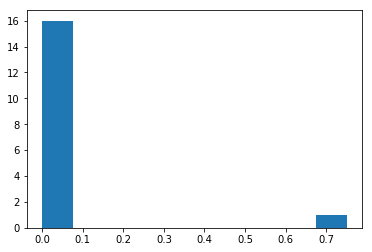

In [81]:
plt.hist(impact_km)
plt.show()

In [82]:
def plot_impact_of_distance(d_range, bins, incidents, series, stations):
    mean_array = np.array([])
    fig, axes = plt.subplots(2, int(bins/2), figsize=[15,7])
    i=0
    for d in np.linspace(d_range[0], d_range[1], bins):
        impact = calculate_affect_degree(incidents, series, stations, d)
        impact = impact[impact != -1.0]
        mean_array = np.append(mean_array, impact.mean())
        axes[int(2*i/bins)][int(i%(bins/2))].hist(impact)
        axes[int(2*i/bins)][int(i%(bins/2))].set_title('{:.3f}'.format(d))
        i += 1
    plt.show()
    return mean_array

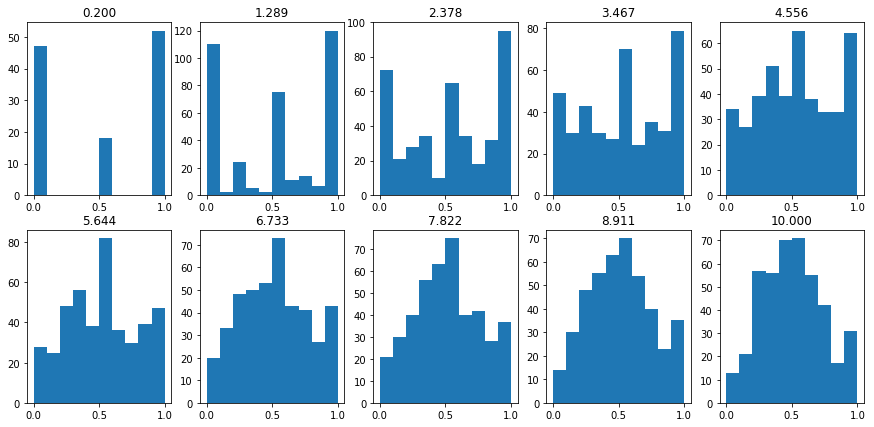

In [41]:
m_ar = plot_impact_of_distance([.2, 10], 10, data_inc_d07, data_srs_smoothed, stations_active)

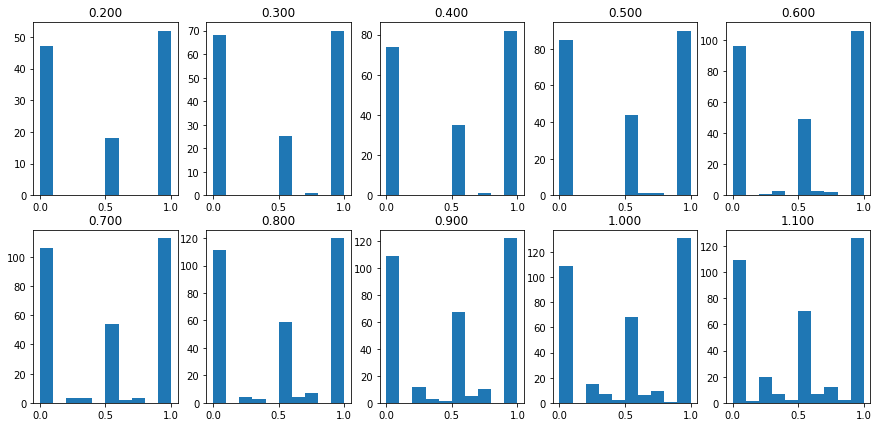

In [42]:
m_ar = plot_impact_of_distance([.2, 1.1], 10, data_inc_d07, data_srs_smoothed, stations_active)

Hot spot station analysis

In [44]:
data_inc_d07.drop(labels=['index', 'IncidentID', 'CC_Code', 'Incident_No', 'Timestamp', 'Description', 'Location', 'Area', 'Zoom_Map', 'TBxy'], axis=1).head()

,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
0,34.006906,-118.060551,7,37.0,56924.0,605,N,R14.648,16.7,NaN,93.0
1,34.010499,-118.281245,7,37.0,44000.0,110,S,19.47,19.4,NaN,8.0
2,34.466522,-118.329716,7,37.0,44000.0,14,N,39.837,15.0,NaN,32.0
3,34.033617,-118.220003,7,37.0,44000.0,5,N,16.867,133.5,NaN,49.0
4,34.051069,-118.213899,7,37.0,44000.0,5,N,18.167,134.8,NaN,2.0


In [992]:
def data_construction(incidents, stations, series, vicinity=2):
    limit_count = 100 #  yields more by one
    counter = 0
    features_count = 6
#     iter_no = 0 
    dataset = np.empty((1,features_count))
#     dataset = np.append(dataset, np.ones((1,1)), axis=0)
    for index,an_inc in incidents.iterrows():
        for stindex, a_station in stations.iterrows(): #get_stations_within_inc_vicinity(incident=an_inc, stations=stations, vicinity=vicinity).iterrows():
            distance = vincenty((an_inc['Latitude'], an_inc['Longitude']), (a_station['Latitude'], a_station['Longitude'])).kilometers
            if distance < vicinity:
#                 print(a_station)

                incID = an_inc['IncidentID']
                stID = a_station['ID']
                absDist = distance #vincenty((an_inc['Latitude'], an_inc['Longitude']), (a_station['Latitude'], a_station['Longitude'])).kilometers
                dirMatch = isDirectionMatching(an_inc, a_station)
                dirCMatch = isDirectionCMatching(an_inc, a_station)
                dwnstrm_st = get_next_downstream_station(stationID=stID, stations=stations, incidents=incidents, incidentID=incID)
                if dwnstrm_st.shape[0] > 0:
                    y = isImpactedWithNextSt(stID, dwnstrm_st.iloc[0]['ID'], series, an_inc['Timestamp'])
#                     if incID == 17521281:
# #                         print('got')
#                         print('{} {} {} {}'.format(stID, dwnstrm_st.iloc[0]['ID'], an_inc['Timestamp'], y))
                else:
                    y = isImpacted(srs=series[series['Station'] == stID], ts=an_inc['Timestamp'] )
                features = np.array([incID, stID, absDist, dirMatch, dirCMatch, y]).reshape(1, features_count)
#                 print(type(stID))
                dataset = np.append(dataset, features, axis=0)
#             iter_no += 1
        if counter >= limit_count:
            break
        counter += 1
    return dataset[1:]

In [993]:
pairs_ds = data_construction(data_inc_d07[data_inc_d07.Timestamp.dt.hour >= 11],stations_active, data_srs_smoothed,2)

In [994]:
sum(pairs_ds[:,-1]==1)

63

In [996]:
sum(pairs_ds[:,-1]==1)/pairs_ds.shape[0]

0.047619047619047616

In [997]:
np.unique(pairs_ds[pairs_ds[:,-1]==1][:,0])

array([ 17521281.,  17521284.,  17521441.,  17521442.,  17521459.,
        17521465.,  17521466.,  17521518.,  17521519.,  17521520.,
        17521529.,  17521530.,  17521540.,  17521542.,  17521567.,
        17521578.,  17521583.,  17521585.,  17521592.,  17521613.,
        17521621.,  17521642.,  17521682.,  17521683.,  17521693.,
        17521702.,  17521704.,  17521706.,  17521718.,  17521719.,
        17521727.,  17521728.,  17521729.,  17521736.])

In [998]:
imp_pairs = pairs_ds[(pairs_ds[:,3] == 1) & (pairs_ds[:,5] == 1)]

In [999]:
rel = np.histogram(imp_pairs[:,2], bins=40)[0]/np.histogram(pairs_ds[:,2], bins=40)[0]

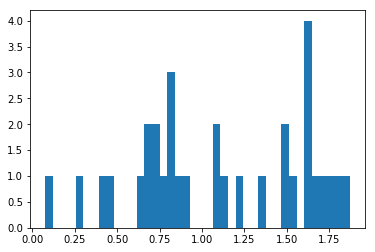

In [1000]:
plt.hist(imp_pairs[:,2], bins=40)
plt.show()

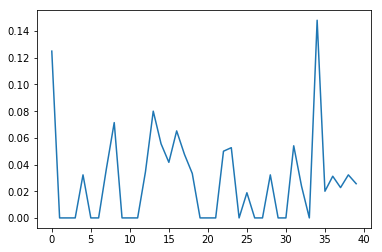

In [1001]:
plt.plot(rel)
plt.show()

In [1056]:
data_det_inc_07.ID.isin(data_inc_d07[data_inc_d07.Duration < 10]['IncidentID'].as_matrix())

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

In [1052]:
data_det_inc_07[data_det_inc_07.ID.isin(data_inc_d07[data_inc_d07.Duration < 10]['IncidentID'])]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

In [1002]:
data_inc_d07[data_inc_d07.IncidentID.isin(pairs_ds[pairs_ds[:,-1]==1][:,0])]

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
176,17521281,LAHB,171011,2017-10-11 11:19:00,1183-Trfc Collision-Unkn Inj,Us101 N / Universal Studios Blvd,LAFSP,NaN,NaN,34.133306,-118.352405,7,37.0,44000.0,101,N,9.652,11.0,NaN,69.0
179,17521284,LAHB,171011,2017-10-11 11:16:00,1125-Traffic Hazard,Sr60 W / Sr57 S,Baldwin Park,NaN,NaN,34.020239,-117.814957,7,37.0,19192.0,60,W,R25.259,25.4,NaN,17.0
204,17521441,LAHB,171011,2017-10-11 12:52:00,1125-Traffic Hazard,Us101 N / I10 W Us101 N Con,LAFSP,NaN,NaN,34.053039,-118.228267,7,37.0,44000.0,101,N,0.252,1.6,NaN,86.0
205,17521442,LAHB,171011,2017-10-11 12:51:00,1125-Traffic Hazard,I10 W / Rosemead Blvd,LAFSP,NaN,NaN,34.072414,-118.072922,7,37.0,22230.0,10,W,26.9,25.4,NaN,27.0
208,17521459,LAHB,171011,2017-10-11 12:58:00,1183-Trfc Collision-Unkn Inj,Sr57 S / Arrow Hwy,Baldwin Park,NaN,NaN,34.106750,-117.821804,7,37.0,66070.0,57,S,R10.691,22.7,NaN,2.0
209,17521465,LAHB,171011,2017-10-11 13:09:00,1183-Trfc Collision-Unkn Inj,I405 N / S Slauson Ave,LAFSP,NaN,NaN,33.989356,-118.400237,7,37.0,17568.0,405,N,26.028,49.8,NaN,18.0
210,17521466,LAHB,171011,2017-10-11 13:07:00,1183-Trfc Collision-Unkn Inj,I405 N / S Slauson Ave,West LA,NaN,NaN,33.989356,-118.400237,7,37.0,17568.0,405,N,26.028,49.8,NaN,26.0
224,17521518,LAHB,171011,2017-10-11 13:32:00,1125-Traffic Hazard,I110 N / W 3rd St,LAFSP,NaN,NaN,34.056084,-118.255871,7,37.0,44000.0,110,N,23.07,23.0,NaN,49.0
225,17521519,LAHB,171011,2017-10-11 13:31:00,1125-Traffic Hazard,I110 N / W 3rd St,Central LA,NaN,NaN,34.056084,-118.255871,7,37.0,44000.0,110,N,23.07,23.0,NaN,21.0
226,17521520,LAHB,171011,2017-10-11 13:30:00,1179-Trfc Collision-1141 Enrt,I110 S / W Manchester Ave,Central LA,NaN,NaN,33.960128,-118.281097,7,37.0,44000.0,110,S,15.97,15.9,NaN,49.0


In [1045]:
incID = 17521542
pairs_ds[(pairs_ds[:,0]== incID) & (pairs_ds[:,-1]==1) & (pairs_ds[:,2]<2)][:,1]

array([ 717659.])

In [923]:
np.unique(pairs_ds[pairs_ds[:,-1]==1][:,1])[:100]

array([ 717486.,  717963.,  718045.,  718376.,  760650.,  761220.,
        764949.,  766788.,  769402.,  769405.,  772872.,  772887.])

In [1046]:
stID = 717659
get_next_downstream_station(stations_active,stID,data_inc_d07, incID)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance
0,773154,210,E,7,37,2462.0,R30.4,30.689,34.148585,-118.057432,0.47,ML,5,VAQUERO,0.006623
1,717667,210,E,7,37,2462.0,R30.95,31.239,34.148636,-118.048053,0.83,ML,4,BALDWIN,0.016002


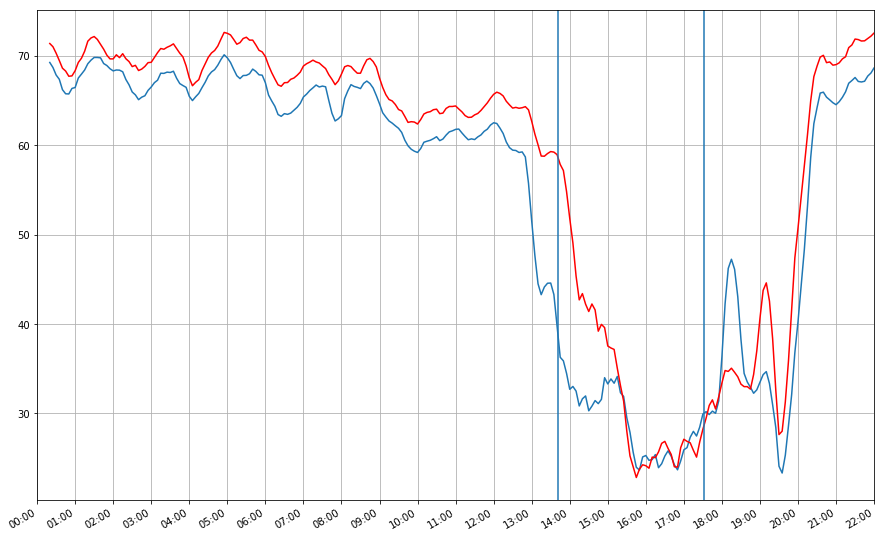

In [1047]:
plot_two_station_data_w_nearest_incds(data_srs_smoothed, data_inc_d07, stations_active, stID, 773154,vicinity_km=2, chrstc_to_plot = 'Avg Speed')

In [796]:
get_neighbouring_station(stations_active,764949)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance
0,769389,101,N,7,37,44000.0,7.7,9.048,34.110196,-118.333961,0.450,ML,4,HIGHLAND,-0.018578
1,717483,101,N,7,37,44000.0,8.11,9.458,34.115601,-118.336660,0.450,ML,5,CAHUENGA,-0.013173
2,769402,101,N,7,37,44000.0,8.6,9.948,34.121951,-118.340170,0.395,ML,6,N/O HIGHLAND,-0.006823
3,769418,101,N,7,37,44000.0,8.9,10.248,34.125162,-118.343673,0.305,ML,5,N/O MULHOLLAND,-0.003612
4,764949,101,N,7,37,44000.0,9.21,10.558,34.128774,-118.346843,0.380,ML,5,BARHAM,0.000000
5,765176,101,N,7,37,44000.0,9.66,11.008,34.133337,-118.352345,0.310,ML,5,UNIVERSAL 1,0.004563
6,764760,101,N,7,37,44000.0,9.83,11.178,34.134078,-118.355163,0.190,ML,5,UNIVERSAL 2,0.005304
7,768469,101,N,7,37,44000.0,10.04,11.388,34.135151,-118.358579,0.350,ML,5,LANKERSHIM,0.006377
8,768253,101,N,7,37,394.0,32.9,34.259,34.138072,-118.726233,0.855,ML,4,LIBERTY CANYON RD 2,0.009298
9,716359,101,N,7,37,44000.0,10.53,11.878,34.139643,-118.365139,0.565,ML,5,LANKERSHIM,0.010869


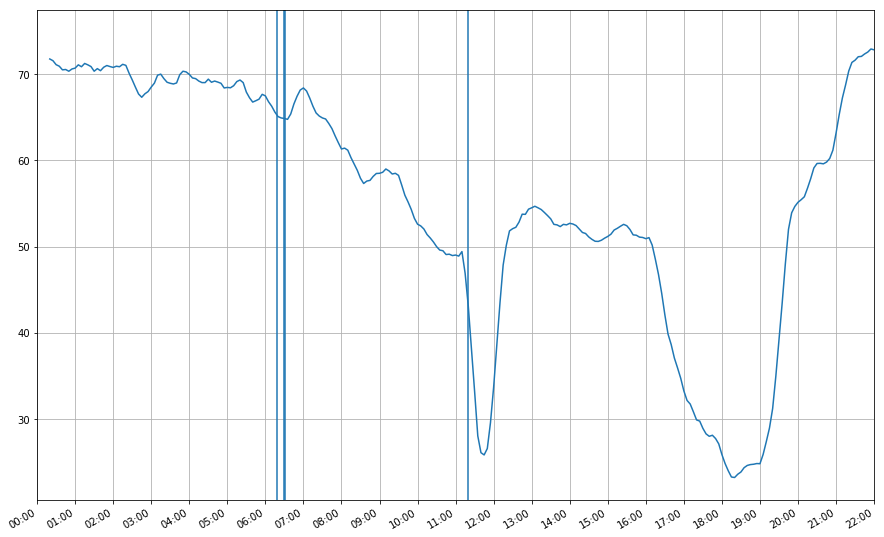

In [503]:
plot_station_data_w_nearest_incds(data_srs_smoothed, data_inc_d07, stations_active, 769405, vicinity_km=2, chrstc_to_plot = 'Avg Speed')

In [ ]:
plot_drctn_station_data_w_nearest_incds(srs_for_smoothing, data_inc_d07, stations_active, 717876, vicinity_km=5, chrstc_to_plot = 'Avg Speed')

In [ ]:
plot_station_data_w_nearest_incds(data_srs_no_null, data_inc_d07, stations_active, 717872, vicinity_km=2, chrstc_to_plot = 'Avg Speed')

In [ ]:
stations_active[stations_active.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), list(stations_active[stations_active['ID'] == 715918].iloc[0][['Latitude', 'Longitude']])).kilometers < 3, axis=1)]

In [742]:
vincenty((34.038096, -118.294389), (34.038096, -118.295389)).kilometers

0.09234352272287202